In [ ]:
import pandas as pd

# Load the datasets
train_df = pd.read_excel('/content/Symptom Severity dataset - 1 -- Val.xlsx')
test_df = pd.read_excel('/content/Symptom Severity dataset - 1 -- Test.xlsx')
val_df = pd.read_excel('/content/Symptom Severity dataset - 1 -- Train.xlsx')

# Display the first few rows of each dataset
train_df.head(), test_df.head(), val_df.head()


(                                                text  labs partition
 0  I got a very bad feeling but I at first ignore...     1       Val
 1  The person needs to have in some manner lived ...     0       Val
 2  I know what it means to dive into oneself. I a...     0       Val
 3  I know it's a young relationship, but it's har...     0       Val
 4  Can't put this under my true account, but I'm ...     0       Val,
                                                 text  labs partition
 0  Now my treatment has stopped this triggering f...   NaN      Test
 1  So I texted her a message saying “7:45” , I se...   NaN      Test
 2  Child protective services were called and I wa...   NaN      Test
 3  Over the past couple of years I've been gettin...   NaN      Test
 4  Certain things will make me feel uncomfortable...   NaN      Test,
                                                 text  labs partition
 0  But those are your most valuable skills, they ...     0     Train
 1  I'm not compet

<ipython-input-28-a560f0b50a8a>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, ax=axs[0], palette=colors)


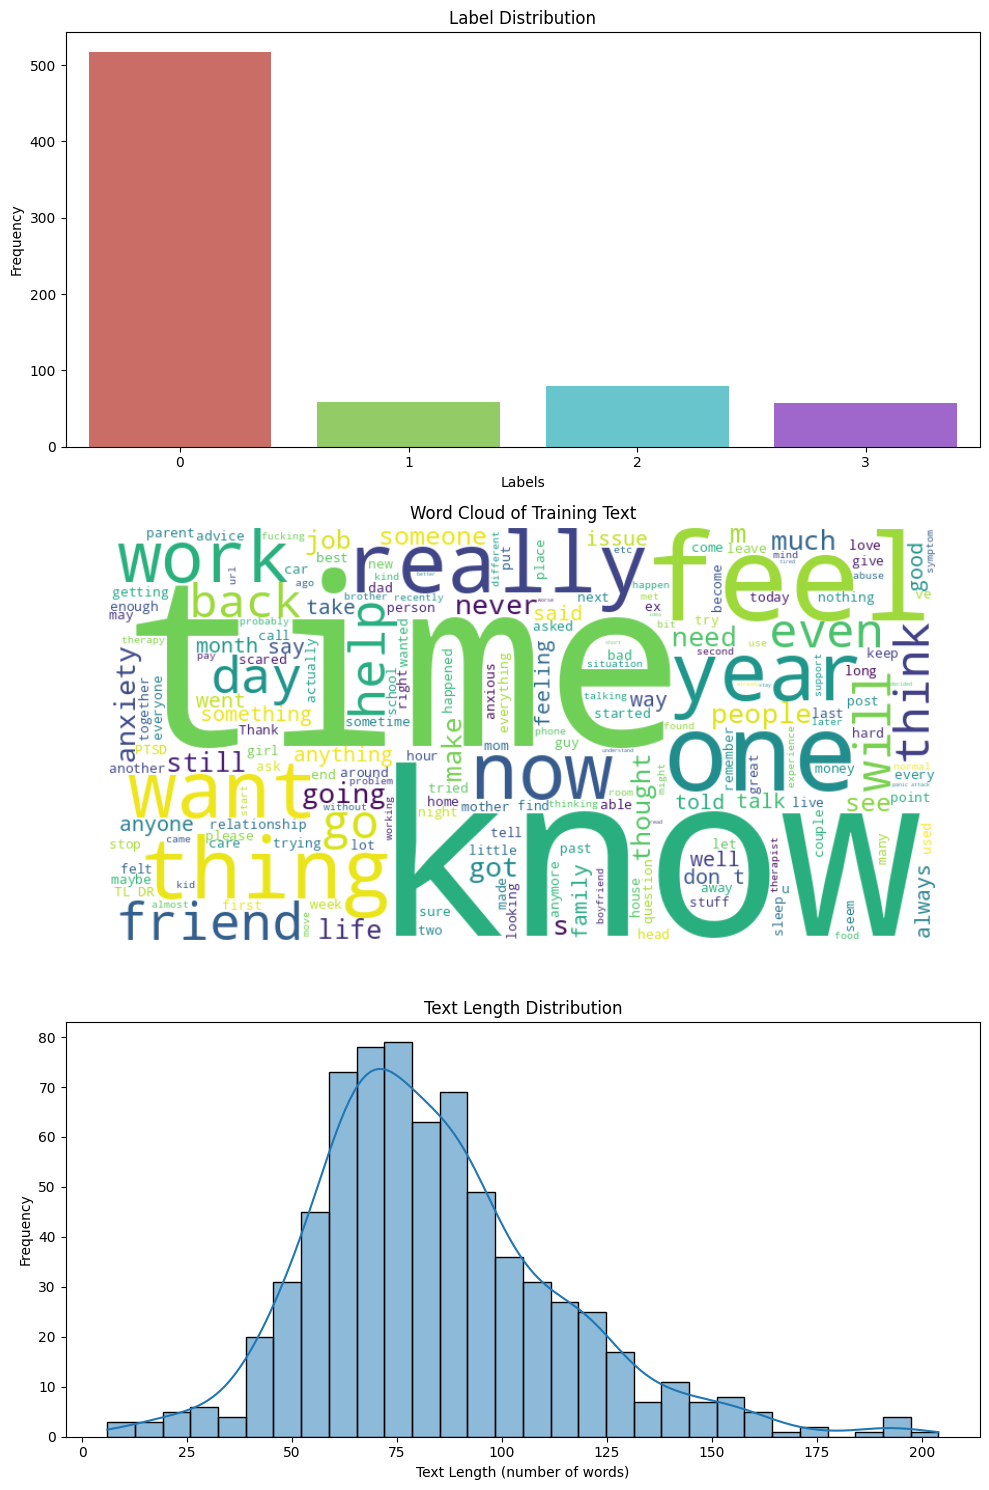

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# Analyzing label distribution
label_counts = train_df['labs'].value_counts()

# Generating a word cloud
text_corpus = " ".join(train_df['text'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)

# Analyzing text length distribution
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
text_length_distribution = train_df['text_length']

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plotting label distribution
colors = sns.color_palette("hls", len(label_counts))
sns.barplot(x=label_counts.index, y=label_counts.values, ax=axs[0], palette=colors)
axs[0].set_title('Label Distribution')
axs[0].set_xlabel('Labels')
axs[0].set_ylabel('Frequency')
axs[0].set_facecolor('white')

# Plotting word cloud
axs[1].imshow(wordcloud, interpolation="bilinear")
axs[1].set_title('Word Cloud of Training Text')
axs[1].axis('off')
axs[1].set_facecolor('white')

# Plotting text length distribution
sns.histplot(text_length_distribution, bins=30, kde=True, ax=axs[2])
axs[2].set_title('Text Length Distribution')
axs[2].set_xlabel('Text Length (number of words)')
axs[2].set_ylabel('Frequency')
axs[2].set_facecolor('white')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
!pip install nltk  # Install the NLTK module if it's not already installed
import nltk  # Import the NLTK module
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk  # Import the NLTK module

# Download the required NLTK components
nltk.download('punkt')
nltk.download('wordnet')


# Define a basic list of stopwords for demonstration
basic_stopwords = {'and', 'is', 'in', 'the', 'to', 'a', 'of', 'for'}

# Define preprocessing functions
def preprocess_text(text):
    """ Apply all preprocessing steps including cleaning, tokenization, stopword removal, stemming, and lemmatization. """
    # Replace NaN values with a placeholder text
    if pd.isna(text):
        text = "missing"

    # Lowercasing
    text = text.lower()

    # Removing URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Removing special sequences and non-alphanumeric characters (except single quotes within words)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # White space removal
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenization
    tokens = word_tokenize(text)

    # Stop Words Removal
    tokens = [word for word in tokens if word not in basic_stopwords]

    # Stemming and Lemmatization
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(stemmer.stem(word)) for word in tokens]

    # Join tokens back to string
    return " ".join(tokens)

# Apply preprocessing
train_df['processed_text'] = train_df['text'].apply(preprocess_text)
val_df['processed_text'] = val_df['text'].apply(preprocess_text)
test_df['processed_text'] = test_df['text'].apply(preprocess_text)

# Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Limit number of features to 1000 for simplicity
X_train = tfidf_vectorizer.fit_transform(train_df['processed_text'])
X_val = tfidf_vectorizer.transform(val_df['processed_text'])
X_test = tfidf_vectorizer.transform(test_df['processed_text'])
y_train = train_df['labs']
y_val = val_df['labs']

# Print the shape of the transformed datasets and a sample of processed text
X_train.shape, X_val.shape, X_test.shape, train_df['processed_text'].head()

# Save the preprocessed data to Excel files
train_df[['processed_text', 'labs']].to_excel('Processed_Train.xlsx', index=False)
val_df[['processed_text', 'labs']].to_excel('Processed_Val.xlsx', index=False)
test_df[['processed_text']].to_excel('Processed_Test.xlsx', index=False)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

# Predict on the validation data
gb_predictions = gb_model.predict(X_val)

# Calculate the accuracy
gb_accuracy = accuracy_score(y_val, gb_predictions)

# Generate the classification report
gb_classification_report = classification_report(y_val, gb_predictions)

# Print the accuracy and classification report
print("Gradient Boosting Classifier Accuracy:", gb_accuracy)
print("\nGradient Boosting Classifier Classification Report:\n", gb_classification_report)

# Predict on the training data
train_predictions = gb_model.predict(X_train)

# Calculate the classification report for training data
train_classification_report = classification_report(y_train, train_predictions, output_dict=True)

# Calculate the macro average recall for training data
train_macro_avg_recall = train_classification_report['macro avg']['recall']

# Print the macro average recall for training data
print("Training Macro Average Recall:", train_macro_avg_recall)

# Calculate the classification report for validation data
val_classification_report = classification_report(y_val, gb_predictions, output_dict=True)

# Calculate the macro average recall for validation data
val_macro_avg_recall = val_classification_report['macro avg']['recall']

# Print the macro average recall for validation data
print("Validation Macro Average Recall:", val_macro_avg_recall)


Gradient Boosting Classifier Accuracy: 0.7264195213514781

Gradient Boosting Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.96      0.85      1552
           1       0.46      0.18      0.26       174
           2       0.34      0.06      0.11       236
           3       0.22      0.08      0.11       169

    accuracy                           0.73      2131
   macro avg       0.45      0.32      0.33      2131
weighted avg       0.65      0.73      0.66      2131

Training Macro Average Recall: 0.9892849211636686
Validation Macro Average Recall: 0.3207883328829812


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd

# Train the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)  # Assuming X_train and y_train are already defined and prepared

# Predict on the test data
gb_predictions = gb_model.predict(X_test)

# Convert predictions into a DataFrame
predictions_df = pd.DataFrame(gb_predictions, columns=['Predicted_Labels'])

# Save the predictions to an Excel file
predictions_df.to_excel('Gradient_Boosting_Test_Predictions.xlsx', index=False)


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score
import pandas as pd

# Initialize XGBoost
xgb_model = XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss', use_label_encoder=False)

# Train XGBoost
xgb_model.fit(X_train, y_train)

# Predict on training and validation datasets
xgb_train_predictions = xgb_model.predict(X_train)
xgb_val_predictions = xgb_model.predict(X_val)

# Calculate accuracy and macro average recall
xgb_train_accuracy = accuracy_score(y_train, xgb_train_predictions)
xgb_val_accuracy = accuracy_score(y_val, xgb_val_predictions)
xgb_train_recall = recall_score(y_train, xgb_train_predictions, average='macro')
xgb_val_recall = recall_score(y_val, xgb_val_predictions, average='macro')

# Predict on the test dataset and save to CSV
xgb_test_predictions = xgb_model.predict(X_test)
xgb_predictions_df = pd.DataFrame(xgb_test_predictions, columns=['Predicted_Labels'])
xgb_predictions_df.to_csv('XGB_Test_Predictions.csv', index=False)

print(f"XGBoost Train Accuracy: {xgb_train_accuracy}, Validation Accuracy: {xgb_val_accuracy}")
print(f"XGBoost Train Macro Avg Recall: {xgb_train_recall}, Validation Macro Avg Recall: {xgb_val_recall}")
print("XGBoost predictions saved to 'XGB_Test_Predictions.csv'")


XGBoost Train Accuracy: 1.0, Validation Accuracy: 0.7203190990145472
XGBoost Train Macro Avg Recall: 1.0, Validation Macro Avg Recall: 0.272790689367218
XGBoost predictions saved to 'XGB_Test_Predictions.csv'


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score
import pandas as pd


# Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train = tfidf_vectorizer.fit_transform(train_df['text'])
X_val = tfidf_vectorizer.transform(val_df['text'])
X_test = tfidf_vectorizer.transform(test_df['text'])
y_train = train_df['labs']
y_val = val_df['labs']

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, multi_class='ovr', class_weight='balanced')
lr_model.fit(X_train, y_train)

# Predict on training and validation datasets
lr_train_predictions = lr_model.predict(X_train)
lr_val_predictions = lr_model.predict(X_val)

# Calculate accuracy and macro average recall
lr_train_accuracy = accuracy_score(y_train, lr_train_predictions)
lr_val_accuracy = accuracy_score(y_val, lr_val_predictions)
lr_train_recall = recall_score(y_train, lr_train_predictions, average='macro')
lr_val_recall = recall_score(y_val, lr_val_predictions, average='macro')

# Predict on the test dataset and save to CSV
lr_test_predictions = lr_model.predict(X_test)
lr_predictions_df = pd.DataFrame(lr_test_predictions, columns=['Predicted_Labels'])
lr_predictions_df.to_csv('/LR_Test_Predictions.csv', index=False)

print(f"Logistic Regression Train Accuracy: {lr_train_accuracy}, Validation Accuracy: {lr_val_accuracy}")
print(f"Logistic Regression Train Macro Avg Recall: {lr_train_recall}, Validation Macro Avg Recall: {lr_val_recall}")
print("Logistic Regression predictions saved to 'LR_Test_Predictions.csv'")


Logistic Regression Train Accuracy: 0.9127988748241913, Validation Accuracy: 0.6518066635382449
Logistic Regression Train Macro Avg Recall: 0.9542471567048115, Validation Macro Avg Recall: 0.39993806926774456
Logistic Regression predictions saved to 'LR_Test_Predictions.csv'
